# **Deep Learning Assignment 2**


1. Rishi Chhabra (M24CSE020)
2. Princu Singh (M24CSA024)
3. Vishvaskumar Patel (M24CSE029)

---

---







## Step:1 Importing Library

---



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms
import torch.optim as optim
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from PIL import Image


## Step:2 Importing Dataset

---



In [ ]:
data_path = "/home/rl_gaming/rishi/cifar100"

In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:

metadata_path = os.path.join(data_path, "meta")
metadata = unpickle(metadata_path)

fine_label_names = [name.decode('utf-8') for name in metadata[b'fine_label_names']]
coarse_label_names = [name.decode('utf-8') for name in metadata[b'coarse_label_names']]

print("Fine Labels (100 Classes):", fine_label_names[:10])
print("Superclasses (20 Groups):", coarse_label_names)


Fine Labels (100 Classes): ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle']
Superclasses (20 Groups): ['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']


In [ ]:

train_dict = unpickle(os.path.join(data_path, "train"))
train_data = train_dict[b'data']
train_labels = np.array(train_dict[b'fine_labels'])
train_coarse_labels = np.array(train_dict[b'coarse_labels'])

test_dict = unpickle(os.path.join(data_path, "test"))
test_data = test_dict[b'data']
test_labels = np.array(test_dict[b'fine_labels'])
test_coarse_labels = np.array(test_dict[b'coarse_labels'])

print(f"Training Data Shape: {train_data.shape}, Labels Shape: {train_labels.shape}")
print(f"Test Data Shape: {test_data.shape}, Labels Shape: {test_labels.shape}")


Training Data Shape: (50000, 3072), Labels Shape: (50000,)
Test Data Shape: (10000, 3072), Labels Shape: (10000,)


## Step: 3 Adding Custom Group Name


1. Plants/Parts of Plants: flowers, trees, fruit and vegetables
2. Vehicles: vehicles 1, vehicles 2
3. Invertebrates: non-insect invertebrates, insects
4. Aquatic Animals: fish, aquatic mammals
5. Large Animals: large carnivores, large omnivores and herbivores
6. Man-made Articles: food containers, household electrical devices, household furniture, large man-made outdoor things
7. People: people
8. Normal Terrestrial Animals: reptiles, medium mammals, small mammals
9. Outdoor Scenes: large natural outdoor scenes

---





In [ ]:
superclass_to_group = {
    "flowers": "Plants/Parts of plants",
    "trees": "Plants/Parts of plants",
    "fruit_and_vegetables": "Plants/Parts of plants",
    "vehicles_1": "Vehicles",
    "vehicles_2": "Vehicles",
    "non-insect_invertebrates": "Invertebrates",
    "insects": "Invertebrates",
    "fish": "Aquatic animals",
    "aquatic_mammals": "Aquatic animals",
    "large_carnivores": "Large animals",
    "large_omnivores_and_herbivores": "Large animals",
    "food_containers": "Man-made articles",
    "household_electrical_devices": "Man-made articles",
    "household_furniture": "Man-made articles",
    "large_man-made_outdoor_things": "Man-made articles",
    "people": "People",
    "reptiles": "Normal Terrestrial Animals",
    "medium_mammals": "Normal Terrestrial Animals",
    "small_mammals": "Normal Terrestrial Animals",
    "large_natural_outdoor_scenes": "Outdoor scenes"
}


group_names = ['Plants/Parts of plants', 'Vehicles', 'Invertebrates', 'Aquatic animals',
               'Large animals', 'Man-made articles', 'People', 'Normal Terrestrial Animals',
               'Outdoor scenes']
group_to_index = {name: idx for idx, name in enumerate(group_names)}


train_group = np.array([group_to_index[superclass_to_group[coarse_label_names[c]]] for c in train_coarse_labels])
test_group  = np.array([group_to_index[superclass_to_group[coarse_label_names[c]]] for c in test_coarse_labels])


In [ ]:
train_data, val_data, train_labels, val_labels, train_coarse_labels, val_coarse_labels, train_group, val_group = train_test_split(
    train_data, train_labels, train_coarse_labels, train_group, test_size=0.2, random_state=42
)

### **Sample Data**

Index: 199
Class Label (Fine): 87 - television
Superclass Label (Coarse): 5 - household_electrical_devices
Group Lbael: 5 - Man-made articles


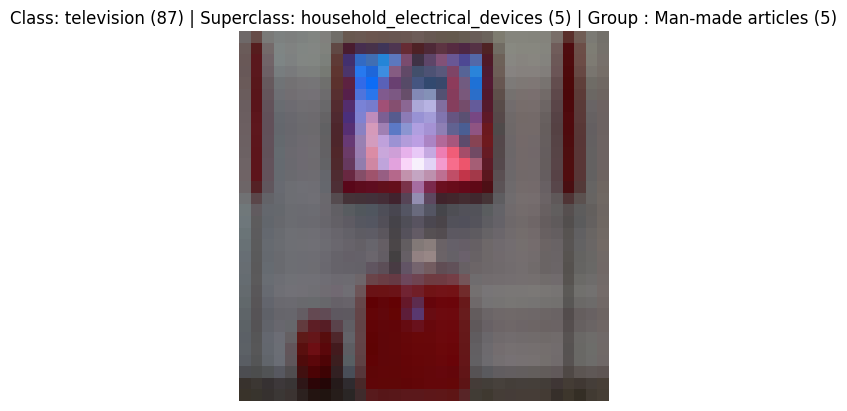

In [ ]:


def show_image(index, dataset="train"):
    if dataset == "train":
        print(f"Index: {index}")
        img = train_data[index].reshape(3, 32, 32).transpose(1, 2, 0)
        label = train_labels[index]
        superclass = train_coarse_labels[index]
        group = train_group[index]
    else:
        print(f"Index: {index}")
        img = test_data[index].reshape(3, 32, 32).transpose(1, 2, 0)
        label = test_labels[index]
        superclass = test_coarse_labels[index]
        group = train_group[index]

    class_name = fine_label_names[label]
    superclass_name = coarse_label_names[superclass]
    group_name = group_names[group]

    print(f"Class Label (Fine): {label} - {class_name}")
    print(f"Superclass Label (Coarse): {superclass} - {superclass_name}")
    print(f"Group Lbael: {group} - {group_name}")

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Class: {class_name} ({label}) | Superclass: {superclass_name} ({superclass}) | Group : {group_name} ({group})")
    plt.show()

show_image(index=199, dataset="train")



## Step: 4 Model Architecture

---



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(1)

print(f"Using device: {device}")
class DeepDualOutputCNN(nn.Module):
    def __init__(self, num_fine_classes, num_coarse_classes, num_group_classes):
        super(DeepDualOutputCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 256, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(256)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512, 512, kernel_size=3, padding='same')
        self.bn4 = nn.BatchNorm2d(512)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.2)

        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding='same')
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding='same')
        self.bn6 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.2)

        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, padding='same')
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding='same')
        self.bn8 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout(0.2)

        self.feature_size = self._get_conv_output_size()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(self.feature_size, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024, momentum=0.95, eps=0.005)
        self.dropout_fc = nn.Dropout(0.2)

        self.fc3_fine = nn.Linear(1024, num_fine_classes)
        self.fc3_coarse = nn.Linear(1024, num_coarse_classes)
        self.fc3_group = nn.Linear(1024, num_group_classes)

    def _get_conv_output_size(self):

        x = torch.randn(1, 3, 32, 32)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.pool3(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.pool4(x)
        return x.numel()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        x = self.dropout4(x)

        x = self.flatten(x)
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc(x)

        fine_out = self.fc3_fine(x)
        coarse_out = self.fc3_coarse(x)
        group_out = self.fc3_group(x)

        return fine_out, coarse_out, group_out



Using device: cuda


### **DataLoader**

In [ ]:

class CIFAR100Dataset(Dataset):
    def __init__(self, data, labels, coarse_labels, group_labels, transform=None):
        self.data = data
        self.labels = labels
        self.coarse_labels = coarse_labels
        self.group_labels = group_labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx].reshape(3, 32, 32).transpose(1, 2, 0)
        img = Image.fromarray(img.astype('uint8'))
        label = self.labels[idx]
        coarse_label = self.coarse_labels[idx]
        group_label = self.group_labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label, coarse_label, group_label

num_fine_classes = 100
num_coarse_classes = 20
num_group_classes = 9

model = DeepDualOutputCNN(num_fine_classes, num_coarse_classes, num_group_classes).to(device)
print(model)

DeepDualOutputCNN(
  (conv1): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=

## **Step: 5 Training and Evalution**

---



In [ ]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

In [ ]:
def calculate_accuracy_and_confusion(model, dataloader, device):
    model.eval()
    correct_fine, correct_coarse, correct_group, total = 0, 0, 0, 0
    all_labels_fine, all_preds_fine = [], []
    all_labels_coarse, all_preds_coarse = [], []
    all_labels_group, all_preds_group = [], []

    with torch.no_grad():
        for inputs, labels, coarse_labels, group_labels in dataloader:
            inputs, labels, coarse_labels, group_labels = inputs.to(device), labels.to(device), coarse_labels.to(device), group_labels.to(device)

            fine_out, coarse_out, group_out = model(inputs)

            _, predicted_fine = torch.max(fine_out, 1)
            _, predicted_coarse = torch.max(coarse_out, 1)
            _, predicted_group = torch.max(group_out, 1)

            total += labels.size(0)
            correct_fine += (predicted_fine == labels).sum().item()
            correct_coarse += (predicted_coarse == coarse_labels).sum().item()
            correct_group += (predicted_group == group_labels).sum().item()

            # Store for confusion matrix
            all_labels_fine.extend(labels.cpu().numpy())
            all_preds_fine.extend(predicted_fine.cpu().numpy())

            all_labels_coarse.extend(coarse_labels.cpu().numpy())
            all_preds_coarse.extend(predicted_coarse.cpu().numpy())

            all_labels_group.extend(group_labels.cpu().numpy())
            all_preds_group.extend(predicted_group.cpu().numpy())

    # Compute confusion matrices
    cm_fine = confusion_matrix(all_labels_fine, all_preds_fine)
    cm_coarse = confusion_matrix(all_labels_coarse, all_preds_coarse)
    cm_group = confusion_matrix(all_labels_group, all_preds_group)

    return (
        100 * correct_fine / total, 100 * correct_coarse / total, 100 * correct_group / total,
        cm_fine, cm_coarse, cm_group
    )

Epoch [1/100], Train Loss: 8.7147, Val Loss: 7.7704, Train Acc: 6.55%, Val Acc: 12.67%
Learning Rate: 0.001000
Epoch [2/100], Train Loss: 7.5727, Val Loss: 6.7573, Train Acc: 15.04%, Val Acc: 20.95%
Learning Rate: 0.001000
Epoch [3/100], Train Loss: 6.7798, Val Loss: 6.2940, Train Acc: 21.77%, Val Acc: 26.47%
Learning Rate: 0.001000
Epoch [4/100], Train Loss: 6.2153, Val Loss: 5.4815, Train Acc: 27.56%, Val Acc: 34.89%
Learning Rate: 0.001000
Epoch [5/100], Train Loss: 5.7581, Val Loss: 5.6213, Train Acc: 32.53%, Val Acc: 33.96%
Learning Rate: 0.001000
Epoch [6/100], Train Loss: 5.3906, Val Loss: 5.4791, Train Acc: 36.49%, Val Acc: 37.72%
Learning Rate: 0.001000
Epoch [7/100], Train Loss: 5.0928, Val Loss: 4.6605, Train Acc: 39.66%, Val Acc: 44.77%
Learning Rate: 0.001000
Epoch [8/100], Train Loss: 4.8556, Val Loss: 4.3336, Train Acc: 42.23%, Val Acc: 48.37%
Learning Rate: 0.001000
Epoch [9/100], Train Loss: 4.6316, Val Loss: 4.1615, Train Acc: 45.12%, Val Acc: 50.21%
Learning Rate: 0.

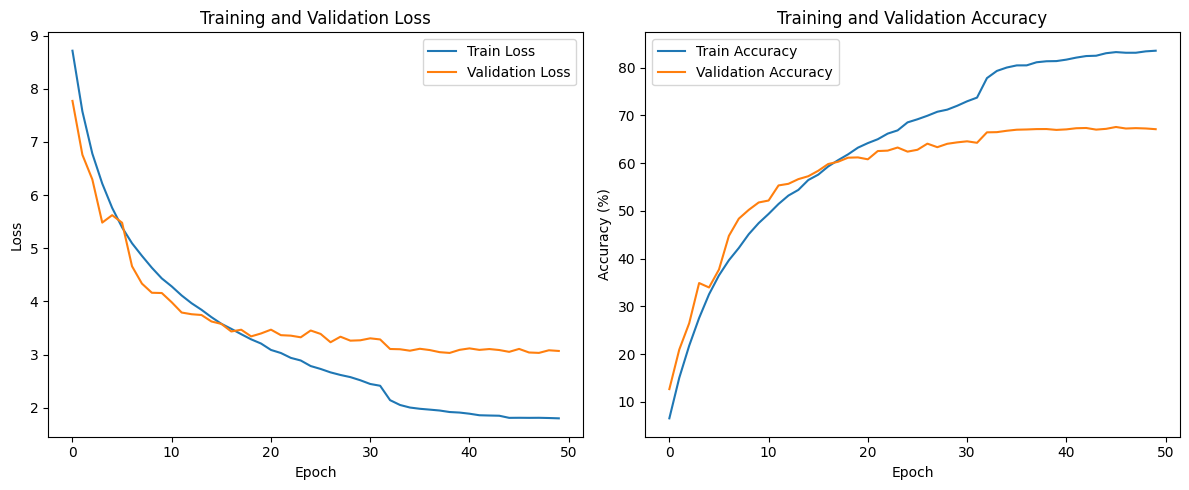

Final Test Accuracy (Fine Classes): 67.22%
Final Test Accuracy (Coarse Classes): 78.97%
Final Test Accuracy (Group Classes): 85.17%


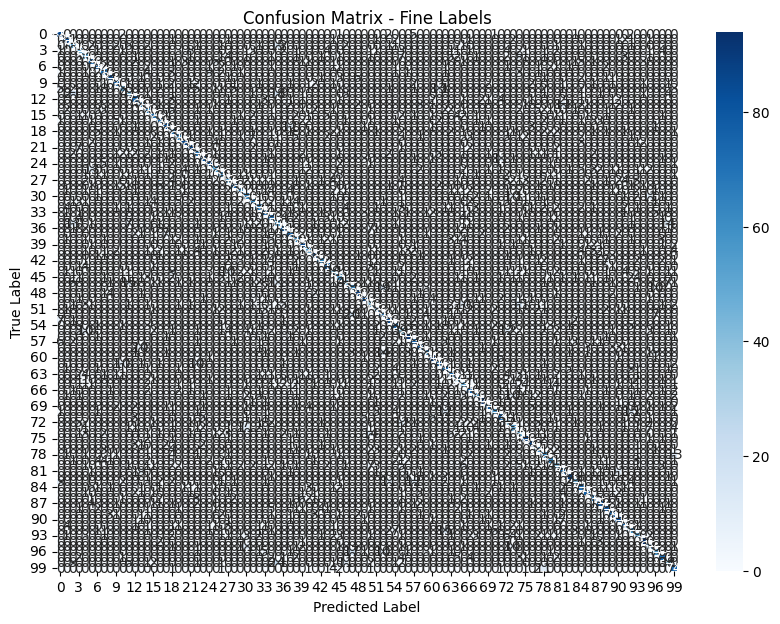

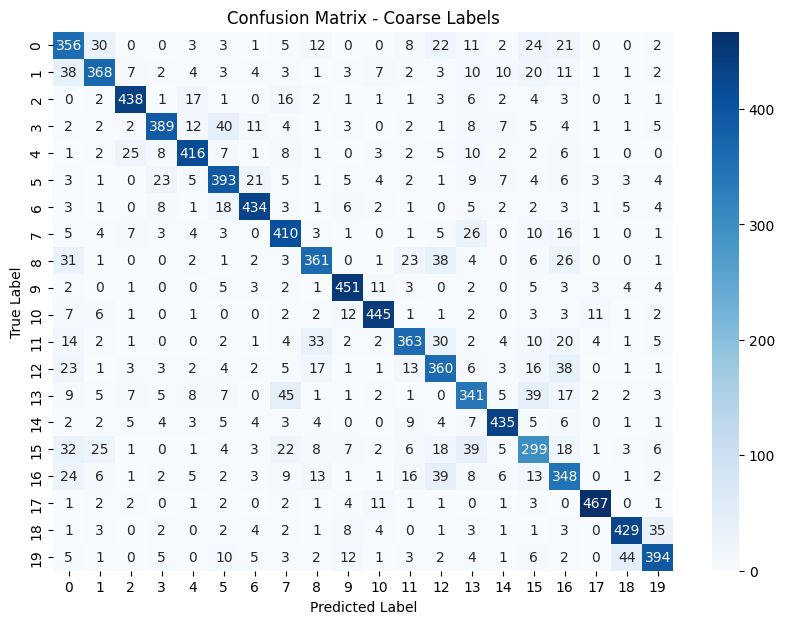

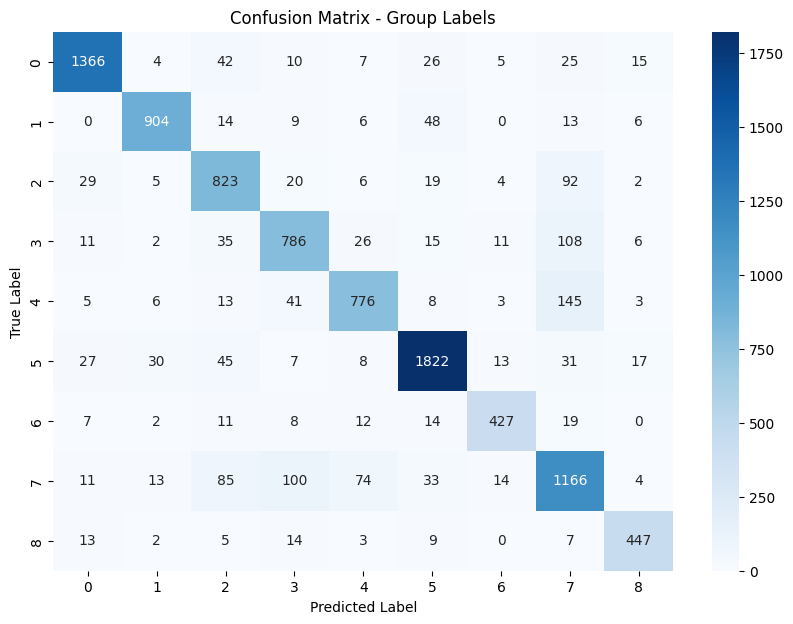

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split

# Loss functions and optimizer
criterion_fine = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion_coarse = nn.CrossEntropyLoss()
criterion_group = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, min_lr=1e-6)

train_transform = transforms.Compose([
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),

    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = CIFAR100Dataset(train_data, train_labels, train_coarse_labels, train_group, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = CIFAR100Dataset(val_data, val_labels, val_coarse_labels, val_group, test_transform)
val_dataloader = DataLoader(val_dataset, batch_size=64,shuffle=False)

test_dataset = CIFAR100Dataset(test_data, test_labels, test_coarse_labels, test_group, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)






num_epochs = 100
patience = 11
min_delta = 0.001
best_val_loss = float('inf')
counter = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    correct_fine = 0
    total = 0

    for inputs, labels, coarse_labels, group_labels in train_dataloader:
        inputs, labels, coarse_labels, group_labels = inputs.to(device), labels.to(device), coarse_labels.to(device), group_labels.to(device)

        optimizer.zero_grad()
        fine_out, coarse_out, group_out = model(inputs)

        loss_fine = criterion_fine(fine_out, labels)
        loss_coarse = criterion_coarse(coarse_out, coarse_labels)
        loss_group = criterion_group(group_out, group_labels)

        loss = loss_fine + loss_coarse + loss_group
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted_fine = torch.max(fine_out.data, 1)
        total += labels.size(0)
        correct_fine += (predicted_fine == labels).sum().item()

    train_loss = running_loss / len(train_dataloader)
    train_acc = 100 * correct_fine / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)


    model.eval()
    val_loss = 0.0
    correct_fine = 0
    total = 0
    with torch.no_grad():
        for inputs, labels, coarse_labels, group_labels in val_dataloader:
            inputs, labels, coarse_labels, group_labels = inputs.to(device), labels.to(device), coarse_labels.to(device), group_labels.to(device)

            fine_out, coarse_out, group_out = model(inputs)
            loss_fine = criterion_fine(fine_out, labels)
            loss_coarse = criterion_coarse(coarse_out, coarse_labels)
            loss_group = criterion_group(group_out, group_labels)
            loss = loss_fine + loss_coarse + loss_group

            val_loss += loss.item()
            _, predicted_fine = torch.max(fine_out.data, 1)
            total += labels.size(0)
            correct_fine += (predicted_fine == labels).sum().item()

    val_loss /= len(val_dataloader)
    val_acc = 100 * correct_fine / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")


    scheduler.step(val_loss)


    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.tight_layout()
plt.show()


model.load_state_dict(torch.load('best_model.pth'))
fine_acc, coarse_acc, group_acc, cm_fine, cm_coarse, cm_group = calculate_accuracy_and_confusion(model, test_dataloader, device)


print(f"Final Test Accuracy (Fine Classes): {fine_acc:.2f}%")
print(f"Final Test Accuracy (Coarse Classes): {coarse_acc:.2f}%")
print(f"Final Test Accuracy (Group Classes): {group_acc:.2f}%")

plot_confusion_matrix(cm_fine, "Confusion Matrix - Fine Labels")
plot_confusion_matrix(cm_coarse, "Confusion Matrix - Coarse Labels")
plot_confusion_matrix(cm_group, "Confusion Matrix - Group Labels")

### Severity without using Custome loss function

In [ ]:
def calculate_severity(fine_true, fine_pred, coarse_labels, group_labels):
    if fine_true != fine_pred:
        if coarse_labels[fine_true] == coarse_labels[fine_pred]:
            return 1
        elif group_labels[fine_true] == group_labels[fine_pred]:
            return 2
        else:
            return 3
    return 0


model.eval()
all_fine_true, all_fine_pred = [], []
with torch.no_grad():
    for inputs, labels, coarse_labels, group_labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        fine_out, _, _ = model(inputs)
        _, predicted_fine = torch.max(fine_out, 1)
        all_fine_true.extend(labels.cpu().numpy())
        all_fine_pred.extend(predicted_fine.cpu().numpy())

severity_counts = {0: 0, 1: 0, 2: 0, 3: 0}
for ft, fp in zip(all_fine_true, all_fine_pred):
    severity = calculate_severity(ft, fp, test_coarse_labels, test_group)
    severity_counts[severity] += 1

print(f"Correct classifications: {severity_counts[0]}")
print(f"Severity 1 misclassifications: {severity_counts[1]}")
print(f"Severity 2 misclassifications: {severity_counts[2]}")
print(f"Severity 3 misclassifications: {severity_counts[3]}")


Correct classifications: 6722
Severity 1 misclassifications: 154
Severity 2 misclassifications: 259
Severity 3 misclassifications: 2865


## **Bonus Task: Severity-Based Loss Function for Misclassification**

---



Epoch [1/100], Train Loss: 10.8637, Val Loss: 8.5294, Train Acc: 41.15%, Val Acc: 51.64%
Learning Rate: 0.001000
Epoch [2/100], Train Loss: 10.4267, Val Loss: 8.7097, Train Acc: 42.88%, Val Acc: 51.65%
Learning Rate: 0.001000
Epoch [3/100], Train Loss: 10.0896, Val Loss: 8.1219, Train Acc: 44.09%, Val Acc: 54.09%
Learning Rate: 0.001000
Epoch [4/100], Train Loss: 9.8132, Val Loss: 8.0586, Train Acc: 45.39%, Val Acc: 54.77%
Learning Rate: 0.001000
Epoch [5/100], Train Loss: 9.5349, Val Loss: 7.8166, Train Acc: 47.16%, Val Acc: 55.93%
Learning Rate: 0.001000
Epoch [6/100], Train Loss: 9.3161, Val Loss: 7.3724, Train Acc: 48.16%, Val Acc: 57.63%
Learning Rate: 0.001000
Epoch [7/100], Train Loss: 9.0301, Val Loss: 7.4023, Train Acc: 49.46%, Val Acc: 57.54%
Learning Rate: 0.001000
Epoch [8/100], Train Loss: 8.8313, Val Loss: 7.3010, Train Acc: 50.49%, Val Acc: 58.03%
Learning Rate: 0.001000
Epoch [9/100], Train Loss: 8.6338, Val Loss: 7.4085, Train Acc: 50.83%, Val Acc: 58.13%
Learning Rate

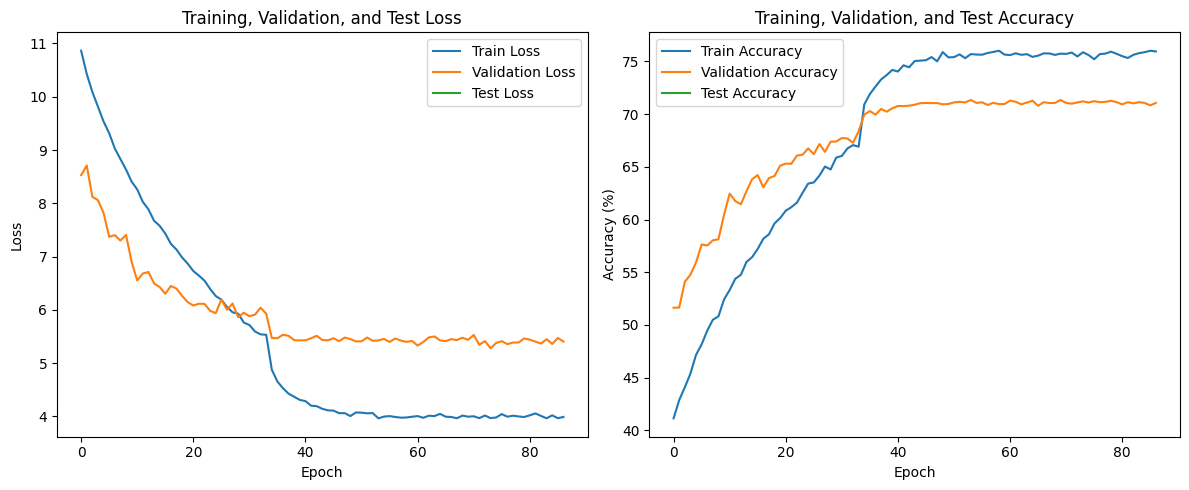

Correct classifications: 7036
Severity 1 misclassifications: 144
Severity 2 misclassifications: 201
Severity 3 misclassifications: 2619
Test Accuracy (Fine Classes): 70.36%


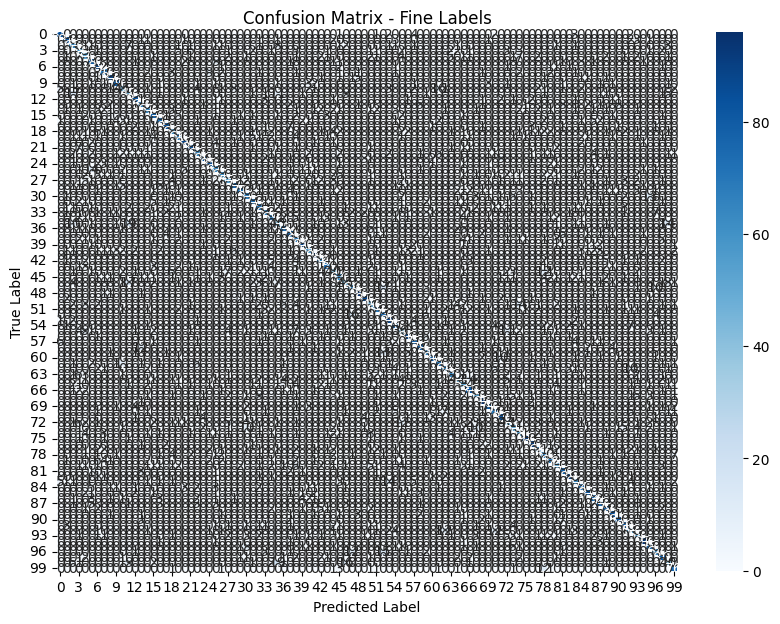

Trainable Parameters: 15816065
Non-Trainable Parameters: 0


In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split

def calculate_severity(fine_true, fine_pred, coarse_labels, group_labels):
    if fine_true != fine_pred:
        if coarse_labels[fine_true] == coarse_labels[fine_pred]:
            return 1
        elif group_labels[fine_true] == group_labels[fine_pred]:
            return 2
        else:
            return 3
    return 0

class SeverityWeightedLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=2.0, gamma=3.0, delta=4.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, fine_out, labels, coarse_labels, group_labels):
        fine_loss = self.ce_loss(fine_out, labels)

        _, predicted_fine = torch.max(fine_out, 1)
        severities = torch.tensor([calculate_severity(ft.item(), fp.item(), test_coarse_labels, test_group)
                                   for ft, fp in zip(labels, predicted_fine)]).to(fine_out.device)

        severity_penalty = torch.where(severities == 1, self.beta,
                              torch.where(severities == 2, self.gamma, self.delta))

        weighted_fine_loss = fine_loss * (self.alpha + severity_penalty)

        return weighted_fine_loss.mean()


criterion = SeverityWeightedLoss(alpha=1.0, beta=2.0, gamma=3.0, delta=4.0)

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, min_lr=1e-6)

train_transform = transforms.Compose([
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),

    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])




train_dataset = CIFAR100Dataset(train_data, train_labels, train_coarse_labels, train_group, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = CIFAR100Dataset(val_data, val_labels, val_coarse_labels, val_group, test_transform)
val_dataloader = DataLoader(val_dataset, batch_size=64,shuffle=False)

test_dataset = CIFAR100Dataset(test_data, test_labels, test_coarse_labels, test_group, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


num_epochs = 100
patience = 13
min_delta = 0.001
best_val_loss = float('inf')
counter = 0
train_losses, val_losses, test_losses = [], [], []
train_accs, val_accs, test_accs = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_fine = 0
    total = 0

    for inputs, labels, coarse_labels, group_labels in train_dataloader:
        inputs, labels, coarse_labels, group_labels = inputs.to(device), labels.to(device), coarse_labels.to(device), group_labels.to(device)

        optimizer.zero_grad()
        fine_out, _, _ = model(inputs)

        loss = criterion(fine_out, labels, coarse_labels, group_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted_fine = torch.max(fine_out.data, 1)
        _, predicted_fine = torch.max(fine_out.data, 1)
        _, predicted_fine = torch.max(fine_out.data, 1)
        total += labels.size(0)
        correct_fine += (predicted_fine == labels).sum().item()

    train_loss = running_loss / len(train_dataloader)
    train_acc = 100 * correct_fine / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)


    model.eval()
    val_loss = 0.0
    correct_fine = 0
    total = 0
    with torch.no_grad():
        for inputs, labels, coarse_labels, group_labels in val_dataloader:
            inputs, labels, coarse_labels, group_labels = inputs.to(device), labels.to(device), coarse_labels.to(device), group_labels.to(device)

            fine_out, _,_ = model(inputs)
            loss = criterion(fine_out, labels, coarse_labels, group_labels)

            val_loss += loss.item()
            _, predicted_fine = torch.max(fine_out.data, 1)
            total += labels.size(0)
            correct_fine += (predicted_fine == labels).sum().item()

    val_loss /= len(val_dataloader)
    val_acc = 100 * correct_fine / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    scheduler.step(val_loss)


    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training, Validation, and Test Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training, Validation, and Test Accuracy')
plt.tight_layout()
plt.show()


model.load_state_dict(torch.load('best_model.pth'))
model.eval()
all_fine_true, all_fine_pred = [], []
with torch.no_grad():
    for inputs, labels, coarse_labels, group_labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        fine_out, _, _ = model(inputs)
        _, predicted_fine = torch.max(fine_out, 1)
        all_fine_true.extend(labels.cpu().numpy())
        all_fine_pred.extend(predicted_fine.cpu().numpy())

severity_counts = {0: 0, 1: 0, 2: 0, 3: 0}
for ft, fp in zip(all_fine_true, all_fine_pred):
    severity = calculate_severity(ft, fp, test_coarse_labels, test_group)
    severity_counts[severity] += 1

print(f"Correct classifications: {severity_counts[0]}")
print(f"Severity 1 misclassifications: {severity_counts[1]}")
print(f"Severity 2 misclassifications: {severity_counts[2]}")
print(f"Severity 3 misclassifications: {severity_counts[3]}")

def calculate_accuracy_and_confusion(model, dataloader, device):
    model.eval()
    correct_fine, correct_coarse, correct_group, total = 0, 0, 0, 0
    all_labels_fine, all_preds_fine = [], []
mo
    with torch.no_grad():
        for inputs, labels, coarse_labels, group_labels in dataloader:
            inputs, labels, coarse_labels, group_labels = inputs.to(device), labels.to(device), coarse_labels.to(device), group_labels.to(device)

            fine_out, _, _ = del(inputs)

            _, predicted_fine = torch.max(fine_out, 1)

            total += labels.size(0)
            correct_fine += (predicted_fine == labels).sum().item()


            all_labels_fine.extend(labels.cpu().numpy())
            all_preds_fine.extend(predicted_fine.cpu().numpy())



    cm_fine = confusion_matrix(all_labels_fine, all_preds_fine)

    return (100 * correct_fine / total, cm_fine)

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()



fine_acc, cm_fine = calculate_accuracy_and_confusion(model, test_dataloader, device)

print(f"Test Accuracy (Fine Classes): {fine_acc:.2f}%")


plot_confusion_matrix(cm_fine, "Confusion Matrix - Fine Labels")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters: {trainable_params}")

non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
print(f"Non-Trainable Parameters: {non_trainable_params}")
